In [77]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point
import json
import pickle
import os
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

path2project = "/Users/don_giraffe/Desktop/TPF/OneDrive_1_2025-6-11"
year_month = '2024-01'

plcs_with_on_off = pd.read_csv(os.path.join(path2project, 'data', 'plcs_with_on_off_jan.csv'))
stops_metadata = pd.read_csv(os.path.join(path2project, 'data', 'stops_metadata_jan.csv'))
def load_line_sequences_json(filename="line_sequences.json"):
    """Load line_sequences from JSON file"""
    filepath = f"data/{filename}"
    with open(filepath, 'r') as f:
        json_data = json.load(f)
    
    # Convert back to original format (strings to ints, lists to tuples)
    line_sequences = {}
    for line_num_str, sequences in json_data.items():
        # Handle both int and float string representations
        line_num = int(float(line_num_str))
        line_sequences[line_num] = {
            int(float(seq_id_str)): tuple(seq) for seq_id_str, seq in sequences.items()
        }
    
    print(f"✅ Loaded line_sequences from {filepath}")
    return line_sequences
line_sequences = load_line_sequences_json()

✅ Loaded line_sequences from data/line_sequences.json


In [83]:
print(plcs_with_on_off)


         Vehicle         Day              Arrival            Departure  \
0            168  2024-01-25  2024-01-25 11:11:51  2024-01-25 11:11:57   
1            168  2024-01-25  2024-01-25 11:13:45  2024-01-25 11:13:45   
2            168  2024-01-25  2024-01-25 11:14:23  2024-01-25 11:14:23   
3            168  2024-01-25  2024-01-25 11:14:56  2024-01-25 11:14:56   
4            168  2024-01-25  2024-01-25 11:15:21  2024-01-25 11:15:21   
...          ...         ...                  ...                  ...   
1226564      855  2024-01-15  2024-01-15 23:18:41  2024-01-15 23:19:04   
1226565      855  2024-01-15  2024-01-15 23:19:52  2024-01-15 23:19:52   
1226566      855  2024-01-15  2024-01-15 23:20:18  2024-01-15 23:20:26   
1226567      855  2024-01-15  2024-01-15 23:21:28  2024-01-15 23:21:37   
1226568      855  2024-01-15  2024-01-15 23:22:39  2024-01-15 23:22:39   

             Punctuality  Distance   Latitude  Longitude  Data  Timetable  \
0        0 days 00:00:57    1244.0

In [84]:
print(stops_metadata)

           Stop                       StopName    Didok  Platform Short_Name  \
0     850023801                  Bulle, Verdel  8500238         1     BULrtv   
1     850023801                  Bulle, Verdel  8500238         1     BULrtv   
2     850023801                  Bulle, Verdel  8500238         1     BULrtv   
3     850023802                  Bulle, Verdel  8500238         2     BULrtv   
4     850072901            Tramelan, garage CJ  8500729         1     DEPtra   
...         ...                            ...      ...       ...        ...   
3902  999998801              Bulle, La Léchère  9999988         1     SPElec   
3903  999998901        Bulle, Rue des Baladins  9999989         1     RUEbal   
3904  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
3905  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
3906  999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   

       Latitude  Longitude  Average_Del

### Waiting time

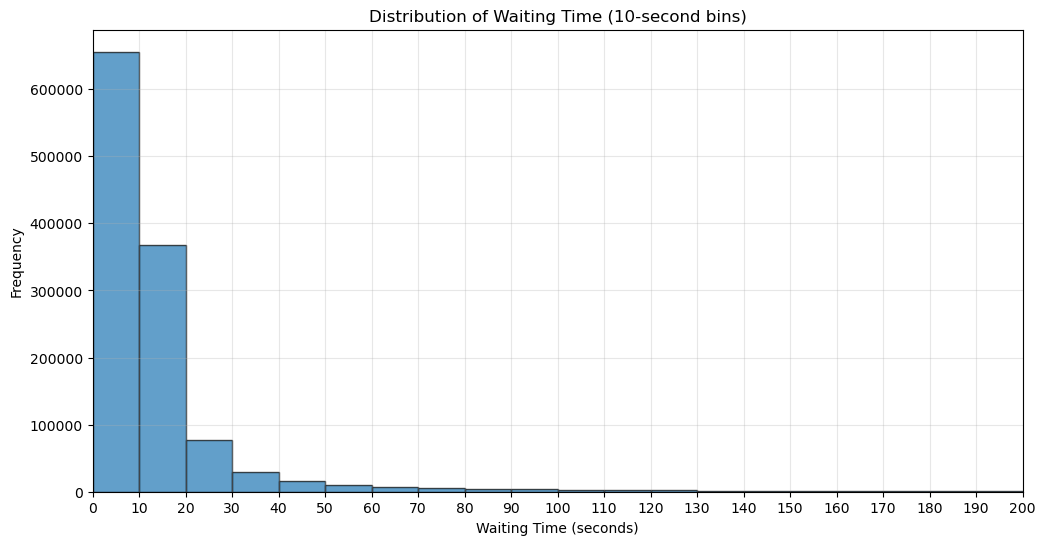

Rows with waiting time > 120 seconds: 45139
Total rows: 1226569
Percentage: 3.68%


In [62]:

# Plot distribution (limit x-axis to 200 seconds with 10-second bins)
plt.figure(figsize=(12, 6))
bins = range(0, 201, 10)  # Create bins every 10 seconds from 0 to 200
plt.hist(plcs_with_on_off['Waiting_Time_Seconds'], bins=bins, alpha=0.7, edgecolor='black')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Time (10-second bins)')
plt.xlim(0, 200)
plt.xticks(range(0, 201, 10))
plt.grid(True, alpha=0.3)
plt.show()

# Count rows with waiting time > 120 seconds
count_over_120 = (plcs_with_on_off['Waiting_Time_Seconds'] > 120).sum()
total_rows = len(plcs_with_on_off)

print(f"Rows with waiting time > 120 seconds: {count_over_120}")
print(f"Total rows: {total_rows}")
print(f"Percentage: {count_over_120/total_rows*100:.2f}%")

In [63]:
# Top 10 stops by passenger boarding activity (On_Second_Class only)
stops = plcs_with_on_off.groupby('StopName')['On_Second_Class'].sum()
top_10_stops = stops.nlargest(10).index.tolist()

# Top 10 lines by passenger boarding activity (On_Second_Class only)
lines = plcs_with_on_off.groupby('Line')['On_Second_Class'].sum()
top_10_lines = lines.nlargest(10).index.tolist()

print("Top 10 Stops (by boarding passengers):")
print(top_10_stops)

print("\nTop 10 Lines (by boarding passengers):")
print(top_10_lines)

Top 10 Stops (by boarding passengers):
['Fribourg/Freiburg, Pl. Gare', 'Fribourg, St-Pierre', 'Fribourg/Freiburg, gare routière', 'Fribourg, Charmettes', 'Fribourg, Tilleul/Cathédrale', 'Fribourg, Industrie', 'Marly, Grand Pré', "Bulle, Château-d'en-Bas", 'Fribourg, Boschung', 'Bulle, Place de la Gare']

Top 10 Lines (by boarding passengers):
[1.0, 2.0, 5.0, 6.0, 8.0, 3.0, 7.0, 202.0, 201.0, 4.0]


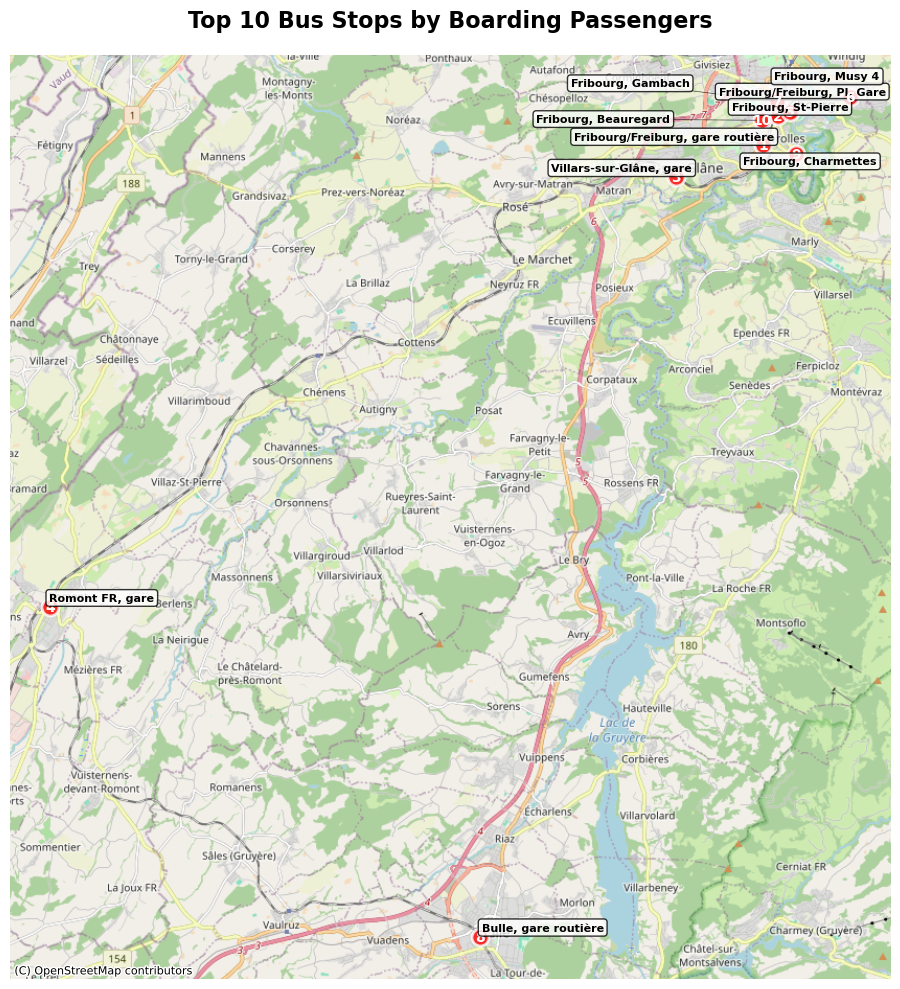

Top 10 stops by boarding passengers:
1. Fribourg/Freiburg, gare routière - 66531 boarding passengers
2. Fribourg/Freiburg, Pl. Gare - 5385 boarding passengers
3. Villars-sur-Glâne, gare - 1556 boarding passengers
4. Romont FR, gare - 1517 boarding passengers
5. Fribourg, St-Pierre - 1484 boarding passengers
6. Fribourg, Musy 4 - 1269 boarding passengers
7. Fribourg, Gambach - 1214 boarding passengers
8. Bulle, gare routière - 1197 boarding passengers
9. Fribourg, Charmettes - 1188 boarding passengers
10. Fribourg, Beauregard - 1173 boarding passengers


In [64]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from adjustText import adjust_text

# Get top 10 stops with coordinates (On_Second_Class only)
stops_data = plcs_with_on_off.groupby(['StopName', 'Latitude', 'Longitude'])['On_Second_Class'].sum()
top_10_stops_coords = stops_data.nlargest(10).reset_index()

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(top_10_stops_coords['Longitude'], top_10_stops_coords['Latitude'])]
gdf = gpd.GeoDataFrame(top_10_stops_coords, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for contextily
gdf = gdf.to_crs('EPSG:3857')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot points
gdf.plot(ax=ax, color='red', markersize=150, alpha=0.8, edgecolor='white', linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Prepare text annotations
texts = []
for i, row in gdf.iterrows():
    # Add ranking number on the point
    ax.annotate(f"{i+1}", xy=(row.geometry.x, row.geometry.y),
                xytext=(0, 0), textcoords='offset points', fontsize=10,
                fontweight='bold', color='white', ha='center', va='center')
    
    # Prepare stop name text for adjustment
    text = ax.text(row.geometry.x, row.geometry.y, row['StopName'], 
                   fontsize=8, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   ha='center', va='bottom')
    texts.append(text)

# Adjust text positions to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', alpha=0.7, lw=0.5))

ax.set_title('Top 10 Bus Stops by Boarding Passengers', fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 10 stops by boarding passengers:")
for i, row in top_10_stops_coords.iterrows():
    print(f"{i+1}. {row['StopName']} - {row['On_Second_Class']:.0f} boarding passengers")

In [65]:
# plcs_with_on_off

In [66]:
n = 1
# Get top 10 lines by boarding passengers (On_Second_Class only)
lines_data = plcs_with_on_off.groupby('Line')['On_Second_Class'].sum()
top_10_lines = lines_data.nlargest(10).index.tolist()

# Filter data for top 10 lines with direction "n" only
line_drawing_df = plcs_with_on_off[
    (plcs_with_on_off['Line'].isin(top_10_lines)) & 
    (plcs_with_on_off['Direction'] == n)
][['Line', 'StopSeq', 'StopName', 'Latitude', 'Longitude']].copy()

# Remove duplicates based on Line and StopName combination, keep first occurrence
line_drawing_df = line_drawing_df.drop_duplicates(subset=['Line', 'StopName']).sort_values(['Line', 'StopSeq']).reset_index(drop=True)

print(f"DataFrame shape: {line_drawing_df.shape}")
print(f"Lines included: {sorted(line_drawing_df['Line'].unique())}")
print("\nFirst few rows:")
print(line_drawing_df.head(10))

# Check uniqueness per line
# print("\nStops per line:")
# for line in sorted(line_drawing_df['Line'].unique()):
#     stops_count = len(line_drawing_df[line_drawing_df['Line'] == line])
#     print(f"Line {line}: {stops_count} unique stops")

DataFrame shape: (167, 5)
Lines included: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 201.0, 202.0]

First few rows:
   Line  StopSeq                        StopName   Latitude  Longitude
0   1.0      1.0           Givisiez, Mont Carmel  46.811680   7.137280
1   1.0      2.0        Fribourg, Jura Chassotte  46.810813   7.139390
2   1.0      3.0          Fribourg, Champ-Fleuri  46.809245   7.140911
3   1.0      4.0   Fribourg, Champ-des-Fontaines  46.809011   7.142340
4   1.0      5.0                Fribourg, Vuille  46.809468   7.145806
5   1.0      6.0           Fribourg, Ste-Thérèse  46.809375   7.149365
6   1.0      7.0           Fribourg, Miséricorde  46.808376   7.151501
7   1.0      8.0            Fribourg, Université  46.806581   7.153425
8   1.0      9.0  Fribourg, Place Georges Python  46.804706   7.155651
9   1.0     10.0             Fribourg, St-Pierre  46.804568   7.155800


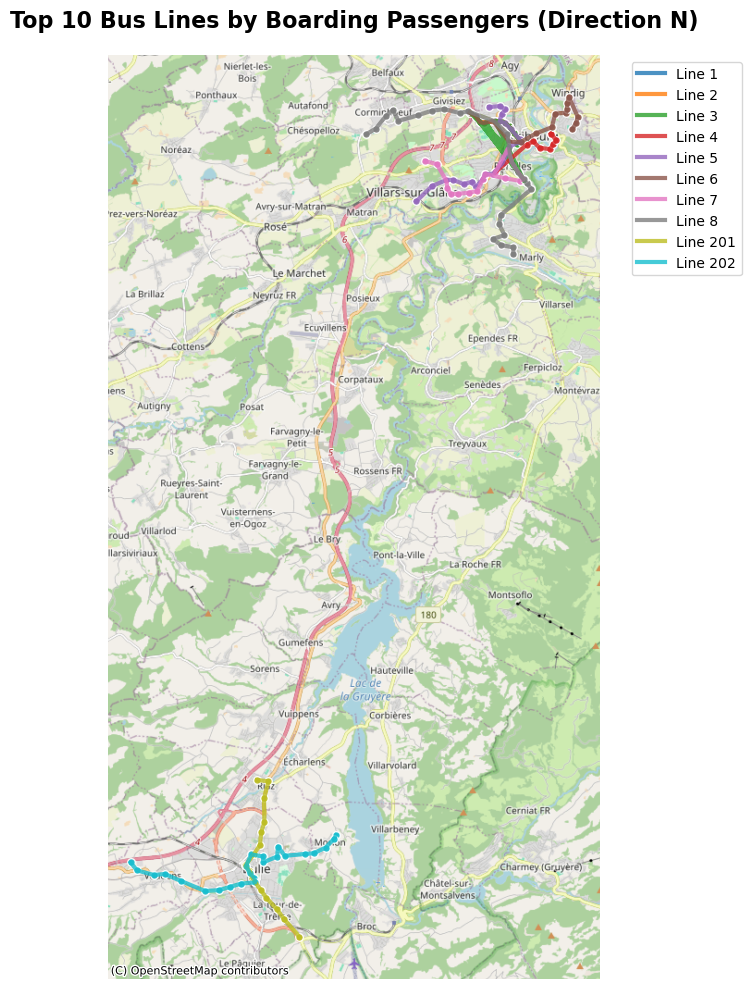

Top 10 lines by boarding passengers:
1. Line 1 - 295637 boarding passengers
2. Line 2 - 261792 boarding passengers
3. Line 3 - 80720 boarding passengers
4. Line 4 - 38412 boarding passengers
5. Line 5 - 225194 boarding passengers
6. Line 6 - 146115 boarding passengers
7. Line 7 - 69403 boarding passengers
8. Line 8 - 119318 boarding passengers
9. Line 201 - 59753 boarding passengers
10. Line 202 - 63081 boarding passengers


In [67]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.colors as mcolors

# Create GeoDataFrame from line_drawing_df
geometry = [Point(xy) for xy in zip(line_drawing_df['Longitude'], line_drawing_df['Latitude'])]
gdf = gpd.GeoDataFrame(line_drawing_df, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for contextily
gdf = gdf.to_crs('EPSG:3857')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Generate distinct colors for each line
unique_lines = sorted(gdf['Line'].unique())
colors = plt.cm.tab10(range(len(unique_lines)))
line_colors = dict(zip(unique_lines, colors))

# Plot each line
for line_num in unique_lines:
    line_data = gdf[gdf['Line'] == line_num].sort_values('StopSeq')
    
    if len(line_data) > 1:  # Need at least 2 points to draw a line
        # Create LineString from the coordinates
        coords = [(row.geometry.x, row.geometry.y) for _, row in line_data.iterrows()]
        line_geom = LineString(coords)
        
        # Plot the line
        ax.plot(*line_geom.xy, color=line_colors[line_num], linewidth=3, 
                alpha=0.8, label=f'Line {int(line_num)}')
        
        # Plot the stops as small points
        line_data.plot(ax=ax, color=line_colors[line_num], markersize=30, 
                      alpha=0.9, edgecolor='white', linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

ax.set_title('Top 10 Bus Lines by Boarding Passengers (Direction N)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 10 lines by boarding passengers:")
for i, line in enumerate(unique_lines, 1):
    total_passengers = lines_data[line]
    print(f"{i}. Line {int(line)} - {total_passengers:.0f} boarding passengers")

In [69]:
plcs_with_on_off

Day              Arrival            Departure  \
Vehicle                                                         
168      2024-01-25  2024-01-25 11:11:51  2024-01-25 11:11:57   
168      2024-01-25  2024-01-25 11:13:45  2024-01-25 11:13:45   
168      2024-01-25  2024-01-25 11:14:23  2024-01-25 11:14:23   
168      2024-01-25  2024-01-25 11:14:56  2024-01-25 11:14:56   
168      2024-01-25  2024-01-25 11:15:21  2024-01-25 11:15:21   
...             ...                  ...                  ...   
855      2024-01-15  2024-01-15 23:18:41  2024-01-15 23:19:04   
855      2024-01-15  2024-01-15 23:19:52  2024-01-15 23:19:52   
855      2024-01-15  2024-01-15 23:20:18  2024-01-15 23:20:26   
855      2024-01-15  2024-01-15 23:21:28  2024-01-15 23:21:37   
855      2024-01-15  2024-01-15 23:22:39  2024-01-15 23:22:39   

             Punctuality  Distance   Latitude  Longitude  Data  Timetable  \
Vehicle                                                                     
168      0 days 00:00:57    1244.0  46.796830   7.146135   263        4.0   
168      0 days 00:01:45     562.0  46.792828   7.143368   263        4.0   
168      0 days 00:01:23     362.0  46.790860   7.140273   263        4.0   
168      0 days 00:01:26     303.0  46.789941   7.136855   263        4.0   
168      0 days 00:01:21     350.0  46.788863   7.132995   263        4.0   
...                  ...       ...        ...        ...   ...        ...   
855      0 days 00:00:34     140.0  46.615696   7.057483   262        1.0   
855      0 days 00:00:52     342.0  46.613355   7.059940   262        1.0   
855      0 days 00:00:56     233.0  46.611631   7.061700   262        1.0   
855      0 days 00:01:37     469.0  46.608675   7.065711   262        1.0   
855      0 days 00:00:39     485.0  46.605475   7.069248   262        1.0   

          Block  JourneySeq   Line  Journey  StopSeq         Stop  \
Vehicle                                                             
168      1025.0         7.0  336.0  33635.0      2.0  858885902.0   
168      1025.0         7.0  336.0  33635.0      3.0  850463301.0   
168      1025.0         7.0  336.0  33635.0      4.0  850463401.0   
168      1025.0         7.0  336.0  33635.0      5.0  850428101.0   
168      1025.0         7.0  336.0  33635.0      6.0  850462301.0   
...         ...         ...    ...      ...      ...          ...   
855      1508.0        43.0  201.0  20924.0     11.0  859328201.0   
855      1508.0        43.0  201.0  20924.0     12.0  857773001.0   
855      1508.0        43.0  201.0  20924.0     13.0  859328801.0   
855      1508.0        43.0  201.0  20924.0     14.0  857773101.0   
855      1508.0        43.0  201.0  20924.0     15.0  859328701.0   

                              StopName  Punctuality_Seconds    Didok  \
Vehicle                                                                
168              Fribourg, bluefactory                 57.0  8588859   
168          Fribourg, Rte de la Glâne                105.0  8504633   
168      Villars-sur-Glâne, Le Moléson                 83.0  8504634   
168      Villars-sur-Glâne, Daillettes                 86.0  8504281   
168       Villars-sur-Glâne, Planafaye                 81.0  8504623   
...                                ...                  ...      ...   
855                    Bulle, St-Denis                 34.0  8593282   
855              Bulle, jardin Anglais                 52.0  8577730   
855        La Tour-de-Trême, St-Michel                 56.0  8593288   
855           La Tour-de-Trême, Centre                 97.0  8577731   
855           La Tour-de-Trême, Le Pra                 39.0  8593287   

         On_Second_Class  Off_Second_Class    Day_Type     Waiting_Time  \
Vehicle                                                                   
168                 1.23              0.06  lu-ve-scol  0 days 00:00:06   
168                 0.15              0.06  lu-ve-scol  0 days 00:00:00   
168                 1.02         

In [70]:
stops_metadata


StopName    Didok  Platform Short_Name  \
Stop                                                                     
850023801                  Bulle, Verdel  8500238         1     BULrtv   
850023801                  Bulle, Verdel  8500238         1     BULrtv   
850023801                  Bulle, Verdel  8500238         1     BULrtv   
850023802                  Bulle, Verdel  8500238         2     BULrtv   
850072901            Tramelan, garage CJ  8500729         1     DEPtra   
...                                  ...      ...       ...        ...   
999998801              Bulle, La Léchère  9999988         1     SPElec   
999998901        Bulle, Rue des Baladins  9999989         1     RUEbal   
999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   
999999201  Châtel-St-Denis, Halle Triple  9999992         1     HALtri   

            Latitude  Longitude  Average_Delay_Seconds  P90_Delay_Seconds  \
Stop                                                                        
850023801  46.625099   7.066065             189.367052              341.0   
850023801  46.625099   7.066065             189.367052              341.0   
850023801  46.625099   7.066065             189.367052              341.0   
850023802  46.624744   7.065967             132.812908              199.2   
850072901  47.246393   7.233253            1015.300000             1900.4   
...              ...        ...                    ...                ...   
999998801  46.617665   7.045063             660.227273              952.4   
999998901  46.610138   7.047311             -38.058824               77.7   
999999201  46.536425   6.897592              26.892116              223.0   
999999201  46.536425   6.897592              26.892116              223.0   
999999201  46.536425   6.897592              26.892116              223.0   

           P50_Delay_Seconds  P10_Delay_Seconds   Line  \
Stop                                                     
850023801              161.0               69.0  202.0   
850023801              161.0               69.0  280.0   
850023801              161.0               69.0  331.0   
850023802              120.0               74.8  202.0   
850072901              742.5              348.7  909.0   
...                      ...                ...    ...   
999998801              573.5              371.6  901.0   
999998901              -63.0             -150.2  901.0   
999999201               25.0             -168.0  481.0   
999999201               25.0             -168.0  492.0   
999999201               25.0             -168.0  902.0   

           Line_Avg_Delay_Seconds  Line_P90_Delay_Seconds  \
Stop                                                        
850023801              190.501837                   341.0   
850023801               33.555556                   143.6   
850023801              179.214286                   326.0   
850023802              132.812908                   199.2   
850072901              998.888889                  1973.2   
...                           ...                     ...   
999998801              660.227273                   952.4   
999998901              -38.058824                    77.7   
999999201              133.600000                   479.0   
999999201              -49.090909                   224.0   
999999201               12.025641                   184.6   

           Line_P50_Delay_Seconds  Line_P10_Delay_Seconds  
Stop                                                       
850023801                   162.0                    70.0  
850023801                    43.0                   -73.8  
850023801                   150.0                    69.1  
850023802                   120.0                    74.8  
850072901                   478.0                   348.1  
...                           ...                     ...  
999998801                   573.5     

# Important lines & stops

1. DEMAND ANALYSIS BY BUS LINE (BOARDING ONLY)

Summary by Bus Line:
        Total_Boarding  Unique_Vehicles  Unique_Journeys
Line                                                    
1.0          295636.73               41              279
2.0          261791.90               48              288
5.0          225194.13               28              260
6.0          146115.06               29              153
8.0          119317.81               66              151
...                ...              ...              ...
903.0          1729.09               23                6
13.0           1719.50               42               32
901.0          1686.12               21                4
259.0          1327.28                3               10
4931.0          653.86                2                1

[77 rows x 3 columns]

2A. HOURLY BOARDING PATTERNS BY LINE

Sample of hourly boarding demand (first few lines and hours):
           Hourly_Boarding
Line Hour                 
1.0  0      

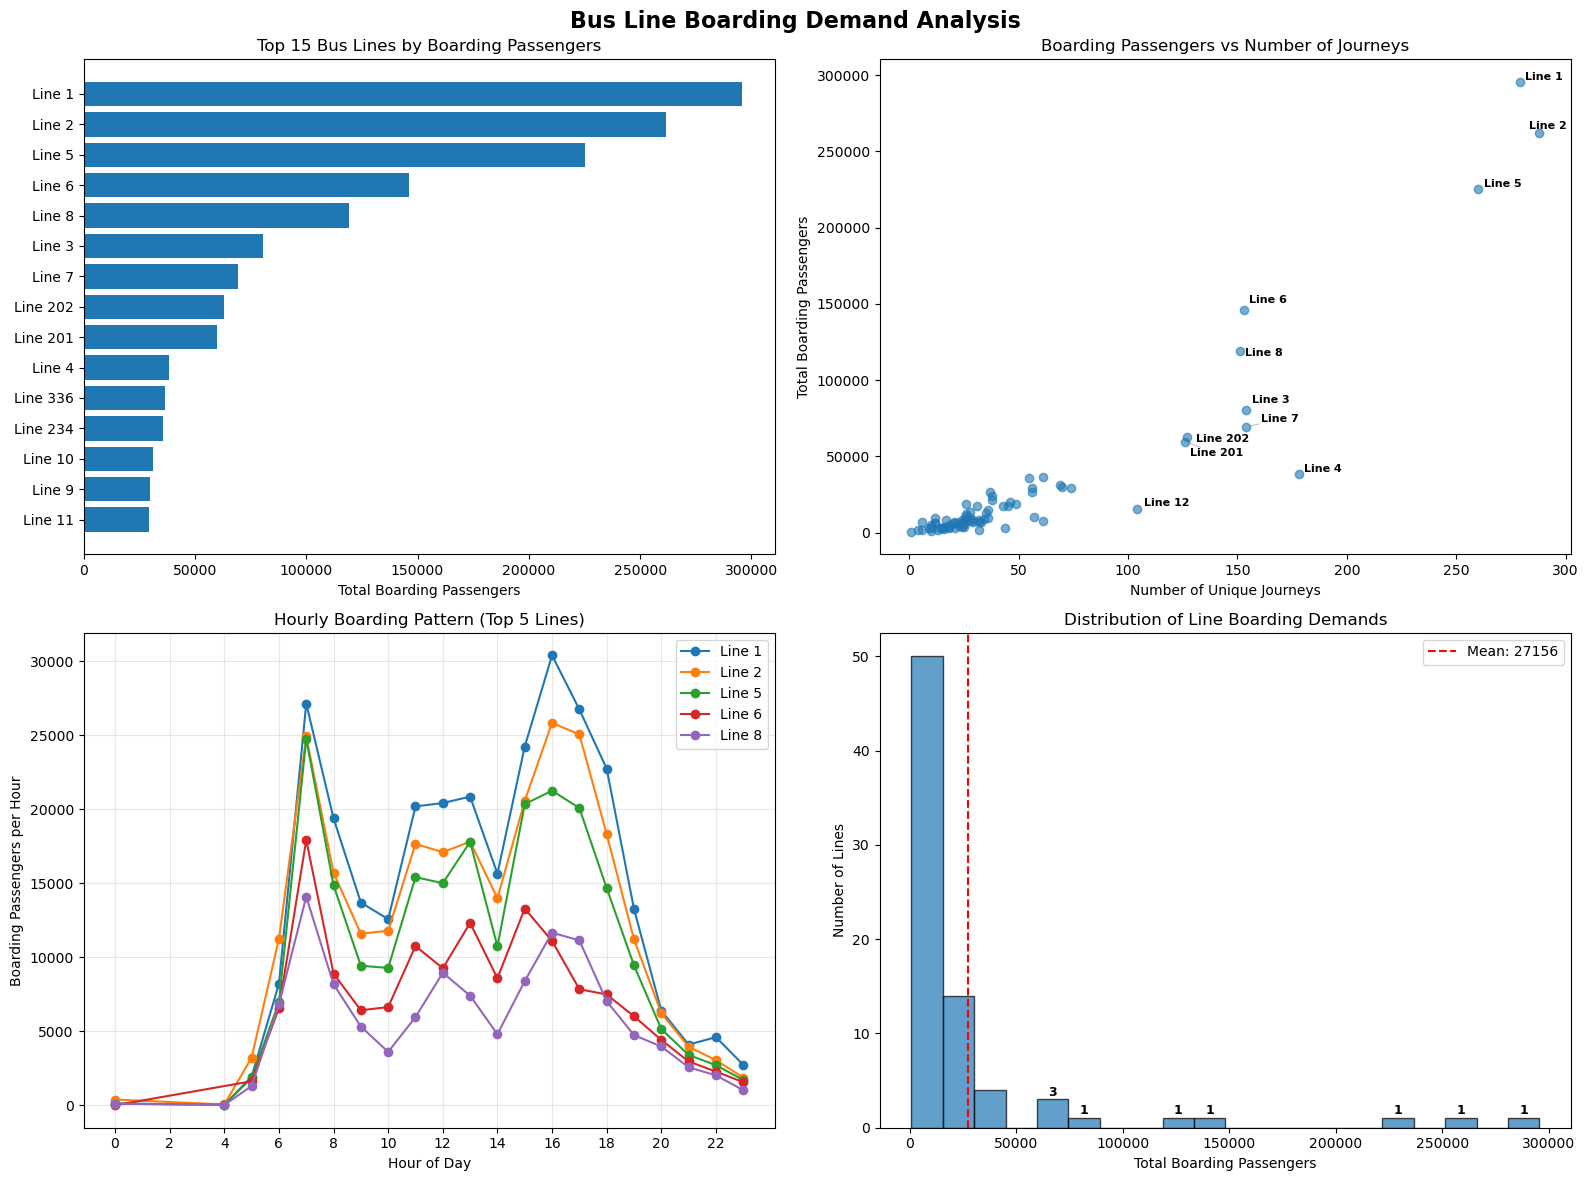

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Assuming your dataframe is called plcs_with_on_off
# df = plcs_with_on_off

def analyze_bus_line_demand(df):
    """
    Comprehensive analysis of bus line demand - Boarding passengers only
    """
    
    # Convert Arrival column to datetime if it's not already
    df['Arrival'] = pd.to_datetime(df['Arrival'])
    df['Hour'] = df['Arrival'].dt.hour
    
    # 1. Basic demand analysis per line (boarding only)
    print("=" * 60)
    print("1. DEMAND ANALYSIS BY BUS LINE (BOARDING ONLY)")
    print("=" * 60)
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    # Calculate total passengers getting on for each line
    line_demand = df_reset.groupby('Line').agg({
        'On_Second_Class': 'sum',
        'Vehicle': 'nunique',  # Number of unique vehicles
        'Journey': 'nunique'   # Number of unique journeys
    }).round(2)
    
    # Rename columns for clarity
    line_demand.columns = ['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys']
    
    print("\nSummary by Bus Line:")
    print(line_demand.sort_values('Total_Boarding', ascending=False))
    
    # 2a. Demand during the day (hourly analysis)
    print("\n" + "=" * 60)
    print("2A. HOURLY BOARDING PATTERNS BY LINE")
    print("=" * 60)
    
    # Create hourly demand analysis
    hourly_demand = df_reset.groupby(['Line', 'Hour']).agg({
        'On_Second_Class': 'sum'
    }).round(2)
    
    hourly_demand.columns = ['Hourly_Boarding']
    
    # Reset index for easier plotting
    hourly_demand_reset = hourly_demand.reset_index()
    
    print("\nSample of hourly boarding demand (first few lines and hours):")
    print(hourly_demand.head(20))
    
    # 2b. Total boarding summary
    print("\n" + "=" * 60)
    print("2B. TOTAL BOARDING BY LINE")
    print("=" * 60)
    
    boarding_summary = df_reset.groupby('Line').agg({
        'On_Second_Class': ['sum', 'mean', 'count']
    }).round(2)
    
    # Flatten column names
    boarding_summary.columns = ['Total_Boarding', 'Avg_Boarding_Per_Stop', 'Boarding_Records']
    
    print("\nBoarding Analysis:")
    print(boarding_summary.sort_values('Total_Boarding', ascending=False))
    
    # 3. Rank bus lines based on boarding demand
    print("\n" + "=" * 60)
    print("3. BUS LINE RANKING BY BOARDING DEMAND")
    print("=" * 60)
    
    # Create comprehensive ranking
    ranking_df = line_demand.copy()
    ranking_df['Demand_Rank'] = ranking_df['Total_Boarding'].rank(ascending=False)
    
    # Sort by total boarding (primary ranking metric)
    ranking_df = ranking_df.sort_values('Total_Boarding', ascending=False)
    ranking_df['Overall_Rank'] = range(1, len(ranking_df) + 1)
    
    print("\nBus Line Rankings (Top 20):")
    print(ranking_df[['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys', 
                     'Overall_Rank']].head(20))
    
    return line_demand, hourly_demand_reset, ranking_df

def create_visualizations(df, line_demand, hourly_demand_reset, ranking_df):
    """
    Create visualizations for the boarding demand analysis
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bus Line Boarding Demand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 lines by total boarding
    top_lines = ranking_df.head(15)
    axes[0, 0].barh(range(len(top_lines)), top_lines['Total_Boarding'])
    axes[0, 0].set_yticks(range(len(top_lines)))
    axes[0, 0].set_yticklabels([f"Line {int(line)}" for line in top_lines.index])
    axes[0, 0].set_xlabel('Total Boarding Passengers')
    axes[0, 0].set_title('Top 15 Bus Lines by Boarding Passengers')
    axes[0, 0].invert_yaxis()
    
    # 2. Boarding vs Journeys scatter plot
    axes[0, 1].scatter(ranking_df['Unique_Journeys'], ranking_df['Total_Boarding'], alpha=0.6)
    axes[0, 1].set_xlabel('Number of Unique Journeys')
    axes[0, 1].set_ylabel('Total Boarding Passengers')
    axes[0, 1].set_title('Boarding Passengers vs Number of Journeys')
    
    # Add text labels for lines with more than 100 unique journeys
    from adjustText import adjust_text
    texts = []
    for line, row in ranking_df.iterrows():
        if row['Unique_Journeys'] > 100:
            text = axes[0, 1].text(row['Unique_Journeys'], row['Total_Boarding'], 
                                 f'Line {int(line)}', fontsize=8, fontweight='bold')
            texts.append(text)
    
    # Adjust text positions to avoid overlap
    if texts:
        adjust_text(texts, ax=axes[0, 1], 
                   arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=0.5))
    
    # 3. Hourly boarding pattern for top 5 lines
    top_5_lines = ranking_df.head(5).index
    for line in top_5_lines:
        line_hourly = hourly_demand_reset[hourly_demand_reset['Line'] == line]
        if not line_hourly.empty:
            axes[1, 0].plot(line_hourly['Hour'], line_hourly['Hourly_Boarding'], 
                           marker='o', label=f'Line {int(line)}')
    
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Boarding Passengers per Hour')
    axes[1, 0].set_title('Hourly Boarding Pattern (Top 5 Lines)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Distribution of line boarding demands
    n, bins, patches = axes[1, 1].hist(ranking_df['Total_Boarding'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Total Boarding Passengers')
    axes[1, 1].set_ylabel('Number of Lines')
    axes[1, 1].set_title('Distribution of Line Boarding Demands')
    axes[1, 1].axvline(ranking_df['Total_Boarding'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {ranking_df["Total_Boarding"].mean():.0f}')
    
    # Add text above bars for bins with >50000 passengers
    for i, (count, left_edge, right_edge) in enumerate(zip(n, bins[:-1], bins[1:])):
        if left_edge > 50000 and count > 0:
            # Position text at the center of the bin, above the bar
            x_pos = (left_edge + right_edge) / 2
            y_pos = count + 0.1  # Slightly above the bar
            axes[1, 1].text(x_pos, y_pos, f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_peak_hours_analysis(df):
    """
    Additional analysis for peak hours (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Hour'] = pd.to_datetime(df_reset['Arrival']).dt.hour
    
    # Overall peak hours
    hourly_total = df_reset.groupby('Hour')['On_Second_Class'].sum()
    peak_hours = hourly_total.nlargest(3)
    
    print("\n" + "=" * 60)
    print("PEAK HOURS ANALYSIS (BOARDING ONLY)")
    print("=" * 60)
    print(f"\nTop 3 Peak Hours (system-wide):")
    for hour, demand in peak_hours.items():
        print(f"Hour {hour:02d}:00 - {demand:.0f} total boardings")
    
    # Peak hours by line (for top 10 lines)
    top_10_lines = df_reset.groupby('Line')['On_Second_Class'].sum().nlargest(10).index
    
    print(f"\nPeak hour for each of the top 10 busiest lines:")
    for line in top_10_lines:
        line_data = df_reset[df_reset['Line'] == line]
        line_hourly = line_data.groupby('Hour')['On_Second_Class'].sum()
        if not line_hourly.empty:
            peak_hour = line_hourly.idxmax()
            peak_demand = line_hourly.max()
            print(f"Line {int(line)}: Peak at {peak_hour:02d}:00 with {peak_demand:.0f} boardings")

# Example usage:
# Uncomment and run the following lines with your dataframe

# line_demand, hourly_demand, ranking = analyze_bus_line_demand(plcs_with_on_off)
# create_visualizations(plcs_with_on_off, line_demand, hourly_demand, ranking)
# generate_peak_hours_analysis(plcs_with_on_off)

# Additional quick summary function
def quick_summary(df):
    """
    Quick summary statistics (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    print("QUICK SUMMARY (BOARDING ONLY)")
    print("=" * 40)
    print(f"Total unique bus lines: {df_reset['Line'].nunique()}")
    print(f"Total unique vehicles: {df_reset['Vehicle'].nunique()}")
    print(f"Total passenger boardings: {df_reset['On_Second_Class'].sum():,.0f}")
    print(f"Average boardings per stop: {df_reset['On_Second_Class'].mean():.2f}")
    print(f"Date range: {df_reset['Day'].min()} to {df_reset['Day'].max()}")
    
# Run the main analysis
line_demand, hourly_demand, ranking = analyze_bus_line_demand(plcs_with_on_off)

# Create visualizations
create_visualizations(plcs_with_on_off, line_demand, hourly_demand, ranking)

# # Generate peak hours analysis
# generate_peak_hours_analysis(plcs_with_on_off)

# # Get quick summary
# quick_summary(plcs_with_on_off)

# Delay Hourly distribution

Selected lines delay statistics:
      Avg_Delay_Seconds  Std_Delay_Seconds  Total_Records
Line                                                     
2.0              132.60             155.17         106449
1.0              108.46             119.56          99211
3.0               95.87             130.02          43682
5.0               72.45              99.10         113250
7.0               64.37             130.33          45543




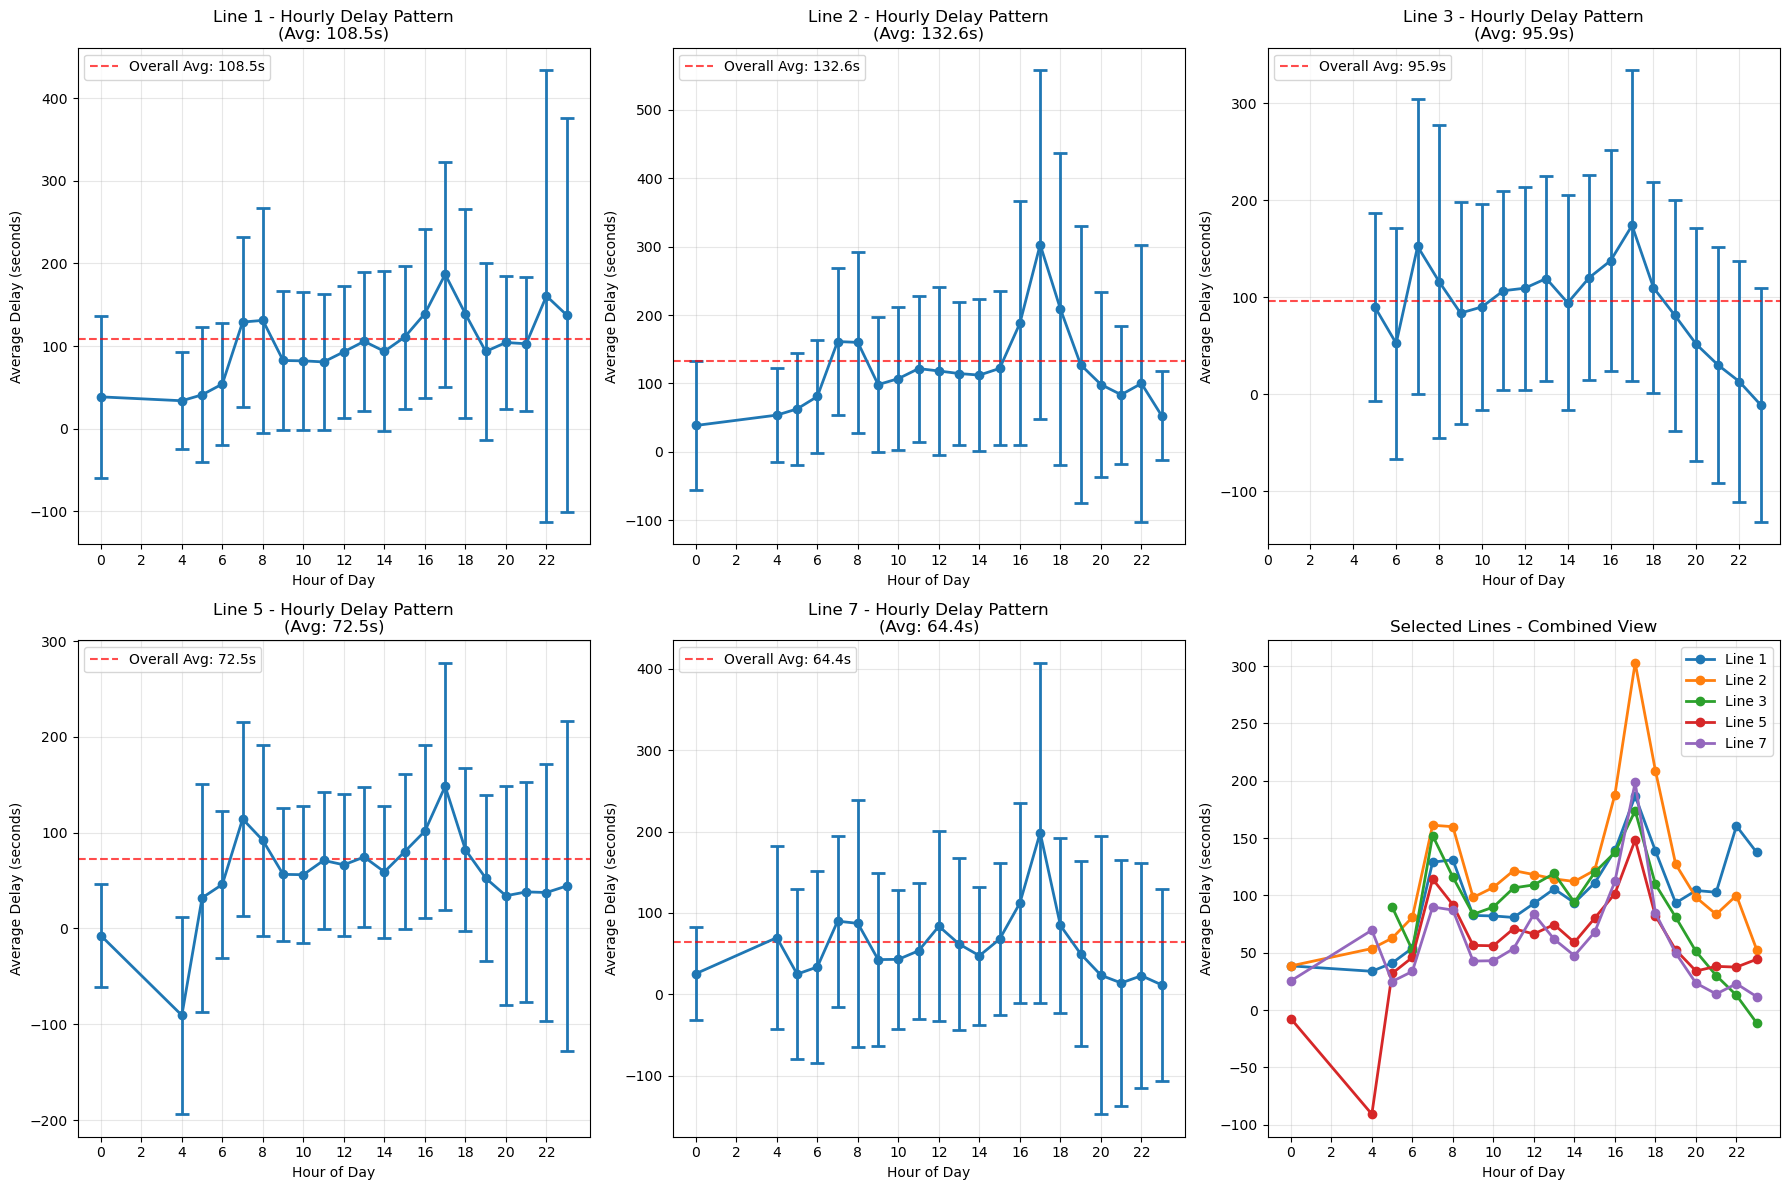

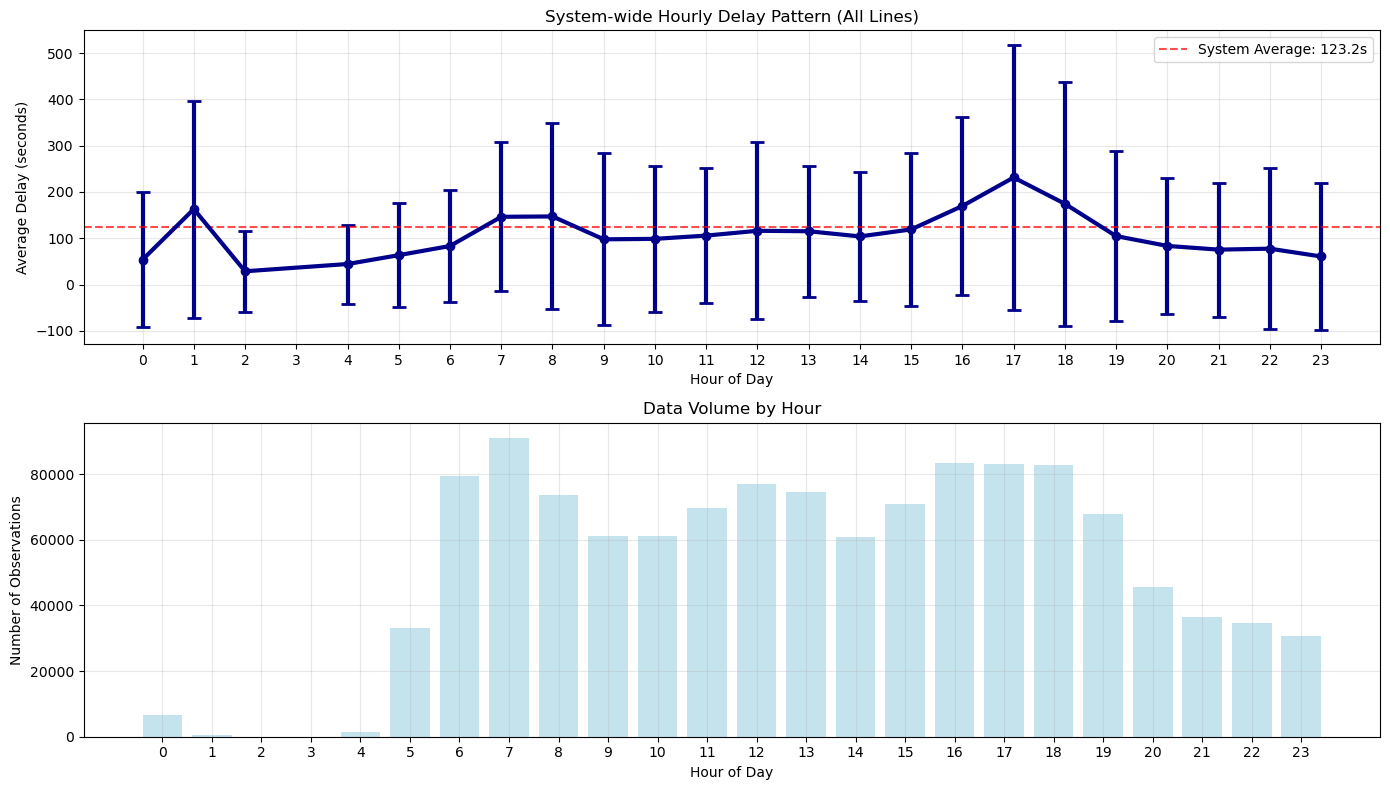

DELAY ANALYSIS SUMMARY
System-wide average delay: 123.23 seconds
Peak delay hour: 17:00 (231.18s)
Best performance hour: 2:00 (28.64s)


In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_hourly_delays(plcs_with_on_off, selected_lines):
    """
    Plot hourly delay patterns for selected bus lines
    
    Parameters:
    plcs_with_on_off: DataFrame with bus data
    selected_lines: List of line numbers to analyze (e.g., [201, 336, 412])
    """
    
    # Calculate average delay by line
    line_delays = plcs_with_on_off.groupby('Line').agg({
        'Punctuality_Seconds': ['mean', 'std', 'count']
    }).round(2)
    
    # Flatten column names
    line_delays.columns = ['Avg_Delay_Seconds', 'Std_Delay_Seconds', 'Total_Records']
    
    # Filter for selected lines only
    available_lines = [line for line in selected_lines if line in line_delays.index]
    if len(available_lines) != len(selected_lines):
        missing_lines = [line for line in selected_lines if line not in line_delays.index]
        print(f"Warning: Lines {missing_lines} not found in data. Available lines will be analyzed.")
    
    selected_delay_lines = line_delays.loc[available_lines]
    print(f"Selected lines delay statistics:")
    print(selected_delay_lines.sort_values('Avg_Delay_Seconds', ascending=False))
    print("\n" + "="*50 + "\n")
    
    # Get the line numbers for plotting
    top_lines = available_lines
    
    # Calculate hourly delays for these top lines
    hourly_delays = plcs_with_on_off[plcs_with_on_off['Line'].isin(top_lines)].groupby(['Line', 'Hour']).agg({
        'Punctuality_Seconds': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    hourly_delays.columns = ['Line', 'Hour', 'Avg_Delay', 'Std_Delay', 'Count']
    
    # Create subplots for individual lines
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, line in enumerate(top_lines):
        if i >= len(axes) - 1:  # Reserve last subplot for combined view
            break
            
        line_hourly = hourly_delays[hourly_delays['Line'] == line]
        
        # Plot average delay with error bars (standard deviation)
        axes[i].errorbar(line_hourly['Hour'], line_hourly['Avg_Delay'], 
                        yerr=line_hourly['Std_Delay'], 
                        marker='o', linewidth=2, capsize=5, capthick=2)
        
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel('Average Delay (seconds)')
        axes[i].set_title(f'Line {int(line)} - Hourly Delay Pattern\n(Avg: {selected_delay_lines.loc[line, "Avg_Delay_Seconds"]:.1f}s)')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(0, 24, 2))
        
        # Add horizontal line for overall average
        axes[i].axhline(y=selected_delay_lines.loc[line, 'Avg_Delay_Seconds'], 
                       color='red', linestyle='--', alpha=0.7, 
                       label=f'Overall Avg: {selected_delay_lines.loc[line, "Avg_Delay_Seconds"]:.1f}s')
        axes[i].legend()
    
    # Combined view in the last subplot
    axes[-1].set_title('Selected Lines - Combined View')
    for line in top_lines:
        line_hourly = hourly_delays[hourly_delays['Line'] == line]
        axes[-1].plot(line_hourly['Hour'], line_hourly['Avg_Delay'], 
                     marker='o', linewidth=2, label=f'Line {int(line)}')
    
    axes[-1].set_xlabel('Hour of Day')
    axes[-1].set_ylabel('Average Delay (seconds)')
    axes[-1].grid(True, alpha=0.3)
    axes[-1].set_xticks(range(0, 24, 2))
    axes[-1].legend()
    
    # Hide any unused subplots
    for j in range(len(top_lines) + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # System-wide hourly delay pattern
    plt.figure(figsize=(14, 8))
    
    # Overall hourly delays across all lines
    system_hourly = plcs_with_on_off.groupby('Hour').agg({
        'Punctuality_Seconds': ['mean', 'std', 'count']
    })
    system_hourly.columns = ['Avg_Delay', 'Std_Delay', 'Count']
    
    # Plot system-wide pattern
    plt.subplot(2, 1, 1)
    plt.errorbar(system_hourly.index, system_hourly['Avg_Delay'], 
                yerr=system_hourly['Std_Delay'], 
                marker='o', linewidth=3, capsize=5, capthick=2, color='darkblue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Delay (seconds)')
    plt.title('System-wide Hourly Delay Pattern (All Lines)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    # Add overall system average line
    overall_avg = plcs_with_on_off['Punctuality_Seconds'].mean()
    plt.axhline(y=overall_avg, color='red', linestyle='--', alpha=0.7, 
               label=f'System Average: {overall_avg:.1f}s')
    plt.legend()
    
    # Plot number of observations per hour
    plt.subplot(2, 1, 2)
    plt.bar(system_hourly.index, system_hourly['Count'], alpha=0.7, color='lightblue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Observations')
    plt.title('Data Volume by Hour')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("DELAY ANALYSIS SUMMARY")
    print("="*50)
    print(f"System-wide average delay: {overall_avg:.2f} seconds")
    print(f"Peak delay hour: {system_hourly['Avg_Delay'].idxmax()}:00 ({system_hourly['Avg_Delay'].max():.2f}s)")
    print(f"Best performance hour: {system_hourly['Avg_Delay'].idxmin()}:00 ({system_hourly['Avg_Delay'].min():.2f}s)")
    
    return hourly_delays, selected_delay_lines, system_hourly

# Example usage:
# Select specific lines to analyze
selected_lines = [1,2,3,5,7]  # Choose any lines you want
hourly_data, selected_stats, system_data = plot_hourly_delays(plcs_with_on_off, selected_lines)

1. DEMAND ANALYSIS BY BUS STOP (BOARDING ONLY)

Summary by Bus Stop (Top 20):
                                  Total_Boarding  Unique_Vehicles  \
StopName                                                            
Fribourg/Freiburg, Pl. Gare            350876.46              115   
Fribourg, St-Pierre                     86008.10               55   
Fribourg/Freiburg, gare routière        69385.57              179   
Fribourg, Charmettes                    67089.04              183   
Fribourg, Tilleul/Cathédrale            60613.69              180   
Fribourg, Industrie                     45092.87              110   
Marly, Grand Pré                        35155.04              170   
Bulle, Château-d'en-Bas                 27376.98              137   
Fribourg, Boschung                      24738.65              161   
Bulle, Place de la Gare                 24530.83               20   
Romont FR, gare                         22720.21              114   
Fribourg, Place Georges P

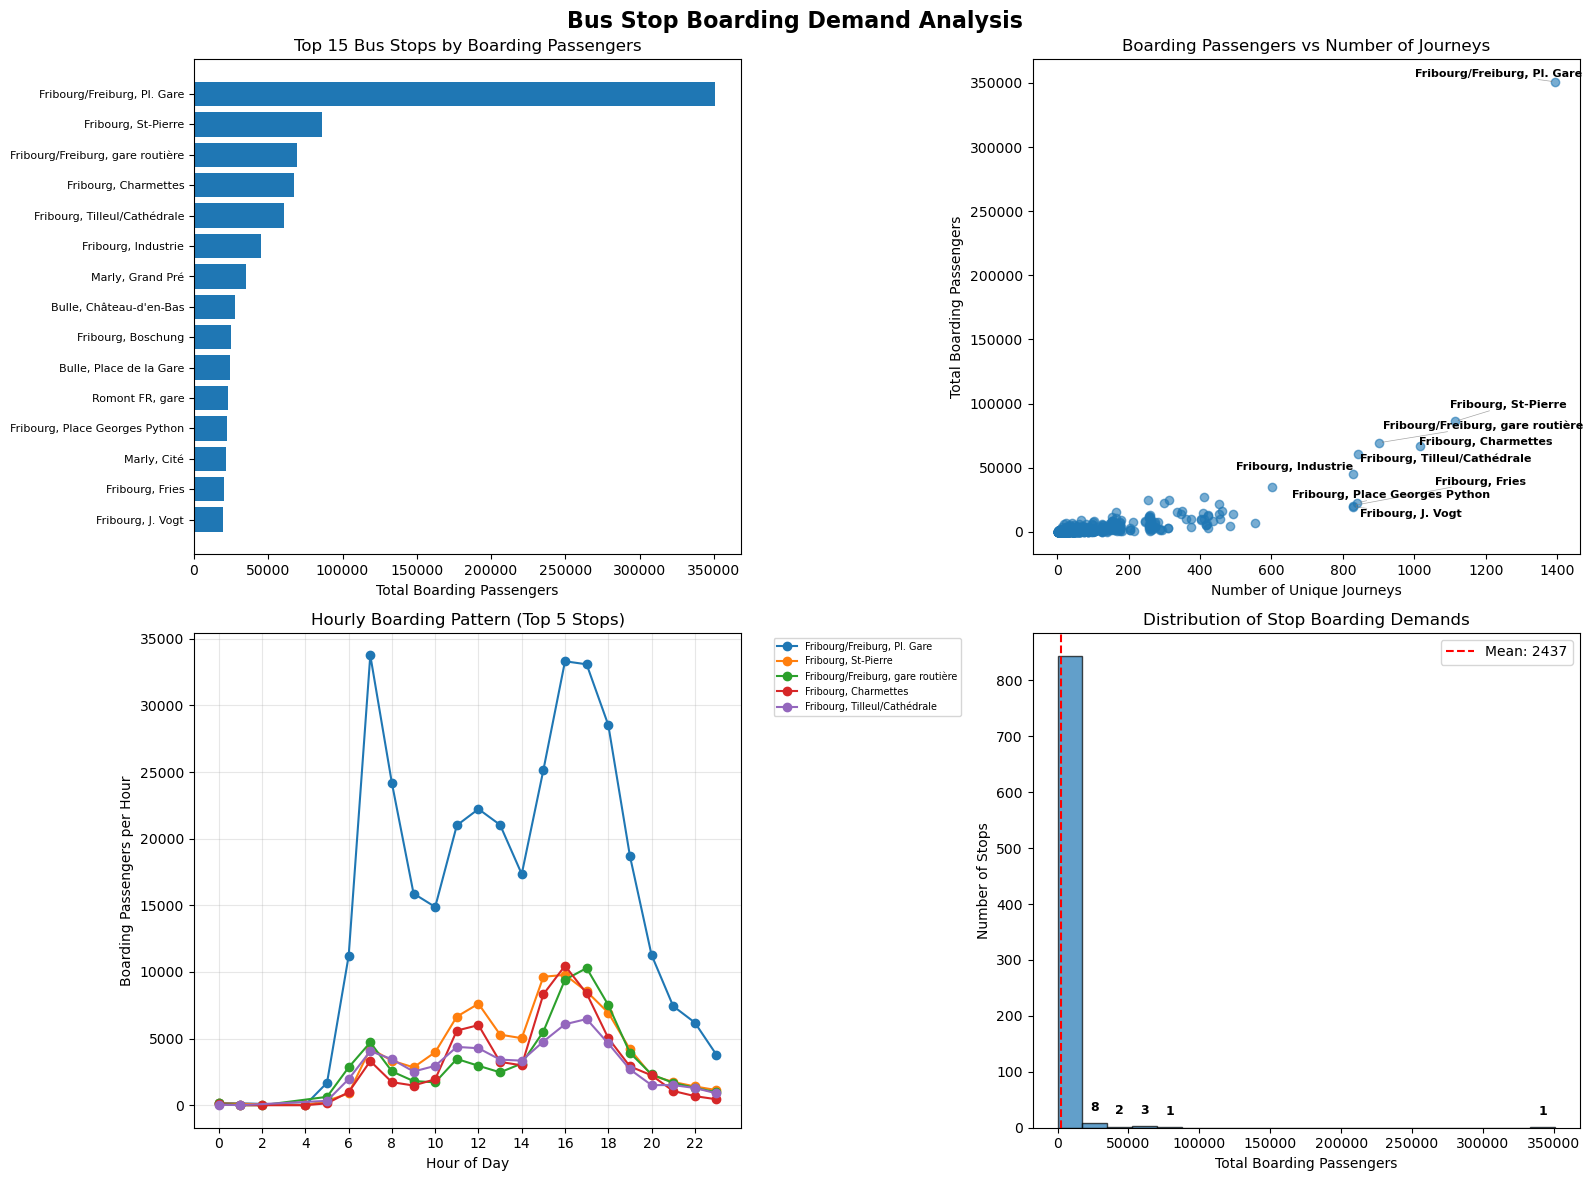

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def analyze_bus_stop_demand(df):
    """
    Comprehensive analysis of bus stop demand - Boarding passengers only
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    # Convert Arrival column to datetime if it's not already
    df_reset['Arrival'] = pd.to_datetime(df_reset['Arrival'])
    df_reset['Hour'] = df_reset['Arrival'].dt.hour
    
    # 1. Basic demand analysis per stop
    print("=" * 60)
    print("1. DEMAND ANALYSIS BY BUS STOP (BOARDING ONLY)")
    print("=" * 60)
    
    # Calculate total passengers getting on for each stop
    stop_demand = df_reset.groupby('StopName').agg({
        'On_Second_Class': 'sum',
        'Vehicle': 'nunique',  # Number of unique vehicles
        'Journey': 'nunique'   # Number of unique journeys
    }).round(2)
    
    # Rename columns for clarity
    stop_demand.columns = ['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys']
    
    print("\nSummary by Bus Stop (Top 20):")
    print(stop_demand.sort_values('Total_Boarding', ascending=False).head(20))
    
    # 2a. Demand during the day (hourly analysis)
    print("\n" + "=" * 60)
    print("2A. HOURLY BOARDING PATTERNS BY STOP")
    print("=" * 60)
    
    # Create hourly demand analysis
    hourly_demand = df_reset.groupby(['StopName', 'Hour']).agg({
        'On_Second_Class': 'sum'
    }).round(2)
    
    hourly_demand.columns = ['Hourly_Boarding']
    
    # Reset index for easier plotting
    hourly_demand_reset = hourly_demand.reset_index()
    
    print("\nSample of hourly boarding demand (first few stops and hours):")
    print(hourly_demand.head(20))
    
    # 3. Rank bus stops based on boarding demand
    print("\n" + "=" * 60)
    print("3. BUS STOP RANKING BY BOARDING DEMAND")
    print("=" * 60)
    
    # Create comprehensive ranking
    ranking_df = stop_demand.copy()
    ranking_df['Demand_Rank'] = ranking_df['Total_Boarding'].rank(ascending=False)
    
    # Sort by total boarding (primary ranking metric)
    ranking_df = ranking_df.sort_values('Total_Boarding', ascending=False)
    ranking_df['Overall_Rank'] = range(1, len(ranking_df) + 1)
    
    print("\nBus Stop Rankings (Top 20):")
    print(ranking_df[['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys', 
                     'Overall_Rank']].head(20))
    
    return stop_demand, hourly_demand_reset, ranking_df

def create_stop_visualizations(df, stop_demand, hourly_demand_reset, ranking_df):
    """
    Create visualizations for the stop boarding demand analysis
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bus Stop Boarding Demand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 stops by total boarding
    top_stops = ranking_df.head(15)
    axes[0, 0].barh(range(len(top_stops)), top_stops['Total_Boarding'])
    axes[0, 0].set_yticks(range(len(top_stops)))
    # Show full stop names
    axes[0, 0].set_yticklabels(top_stops.index, fontsize=8)
    axes[0, 0].set_xlabel('Total Boarding Passengers')
    axes[0, 0].set_title('Top 15 Bus Stops by Boarding Passengers')
    axes[0, 0].invert_yaxis()
    
    # 2. Boarding vs Journeys scatter plot
    axes[0, 1].scatter(ranking_df['Unique_Journeys'], ranking_df['Total_Boarding'], alpha=0.6)
    axes[0, 1].set_xlabel('Number of Unique Journeys')
    axes[0, 1].set_ylabel('Total Boarding Passengers')
    axes[0, 1].set_title('Boarding Passengers vs Number of Journeys')
    
    # Add text labels for stops with more than 800 unique journeys
    from adjustText import adjust_text
    texts = []
    for stop, row in ranking_df.iterrows():
        if row['Unique_Journeys'] > 800:
            # Show full stop name
            text = axes[0, 1].text(row['Unique_Journeys'], row['Total_Boarding'], 
                                 stop, fontsize=8, fontweight='bold')
            texts.append(text)
    
    # Adjust text positions to avoid overlap
    if texts:
        adjust_text(texts, ax=axes[0, 1], 
                   arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=0.5))
    
    # 3. Hourly boarding pattern for top 5 stops
    top_5_stops = ranking_df.head(5).index
    for stop in top_5_stops:
        stop_hourly = hourly_demand_reset[hourly_demand_reset['StopName'] == stop]
        if not stop_hourly.empty:
            # Show full stop name in legend
            axes[1, 0].plot(stop_hourly['Hour'], stop_hourly['Hourly_Boarding'], 
                           marker='o', label=stop)
    
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Boarding Passengers per Hour')
    axes[1, 0].set_title('Hourly Boarding Pattern (Top 5 Stops)')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Distribution of stop boarding demands
    n, bins, patches = axes[1, 1].hist(ranking_df['Total_Boarding'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Total Boarding Passengers')
    axes[1, 1].set_ylabel('Number of Stops')
    axes[1, 1].set_title('Distribution of Stop Boarding Demands')
    axes[1, 1].axvline(ranking_df['Total_Boarding'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {ranking_df["Total_Boarding"].mean():.0f}')
    
    # Add text above bars for bins with >5000 passengers (adjusted threshold for stops)
    for i, (count, left_edge, right_edge) in enumerate(zip(n, bins[:-1], bins[1:])):
        if left_edge > 5000 and count > 0:
            # Position text at the center of the bin, above the bar
            x_pos = (left_edge + right_edge) / 2
            y_pos = count + max(n) * 0.02  # Slightly above the bar
            axes[1, 1].text(x_pos, y_pos, f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_stop_peak_hours_analysis(df):
    """
    Additional analysis for peak hours at stops (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Hour'] = pd.to_datetime(df_reset['Arrival']).dt.hour
    
    # Overall peak hours
    hourly_total = df_reset.groupby('Hour')['On_Second_Class'].sum()
    peak_hours = hourly_total.nlargest(3)
    
    print("\n" + "=" * 60)
    print("PEAK HOURS ANALYSIS FOR STOPS (BOARDING ONLY)")
    print("=" * 60)
    print(f"\nTop 3 Peak Hours (system-wide):")
    for hour, demand in peak_hours.items():
        print(f"Hour {hour:02d}:00 - {demand:.0f} total boardings")
    
    # Peak hours by stop (for top 10 stops)
    top_10_stops = df_reset.groupby('StopName')['On_Second_Class'].sum().nlargest(10).index
    
    print(f"\nPeak hour for each of the top 10 busiest stops:")
    for stop in top_10_stops:
        stop_data = df_reset[df_reset['StopName'] == stop]
        stop_hourly = stop_data.groupby('Hour')['On_Second_Class'].sum()
        if not stop_hourly.empty:
            peak_hour = stop_hourly.idxmax()
            peak_demand = stop_hourly.max()
            stop_display = stop[:30] + '...' if len(stop) > 30 else stop
            print(f"{stop_display}: Peak at {peak_hour:02d}:00 with {peak_demand:.0f} boardings")

def quick_stop_summary(df):
    """
    Quick summary statistics for stops (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    print("QUICK SUMMARY FOR STOPS (BOARDING ONLY)")
    print("=" * 40)
    print(f"Total unique bus stops: {df_reset['StopName'].nunique()}")
    print(f"Total unique vehicles: {df_reset['Vehicle'].nunique()}")
    print(f"Total passenger boardings: {df_reset['On_Second_Class'].sum():,.0f}")
    print(f"Average boardings per record: {df_reset['On_Second_Class'].mean():.2f}")
    print(f"Date range: {df_reset['Day'].min()} to {df_reset['Day'].max()}")

# Run the main analysis
stop_demand, hourly_demand, ranking = analyze_bus_stop_demand(plcs_with_on_off)

# Create visualizations
create_stop_visualizations(plcs_with_on_off, stop_demand, hourly_demand, ranking)

# # Generate peak hours analysis
# generate_stop_peak_hours_analysis(plcs_with_on_off)

# # Get quick summary
# quick_stop_summary(plcs_with_on_off)

# Delay Analysis

## Stop Delay

### Delay Sum

In [73]:
import pandas as pd
import numpy as np

def analyze_top_delays_weighted(df, n_stops=5, m_lines=3, min_occurrences=100):
    """
    Find top delay stations and lines by total delay impact
    Impact = sum of (delay × passenger_count) - shows total passenger-time lost
    Aggregates by Didok (station) instead of individual Stop IDs
    """
    
    # Reset index if needed
    if df.index.name == 'Vehicle':
        df = df.reset_index()
    
    # Filter stops with enough data (by Didok)
    didok_counts = df['Didok'].value_counts()
    frequent_didoks = didok_counts[didok_counts > min_occurrences].index
    df_filtered = df[df['Didok'].isin(frequent_didoks)]
    
    print(f"Analyzing {len(frequent_didoks)} stations (Didok) with > {min_occurrences} records")
    
    # Calculate weighted median for each Didok station
    didok_results = []
    for didok_id in frequent_didoks:
        didok_data = df_filtered[df_filtered['Didok'] == didok_id]
        
        # Calculate delay impact (delay * passengers)
        delays = didok_data['Punctuality_Seconds']
        passengers = didok_data['Passenger_Count']
        
        # Total delay impact = sum of (delay * passengers)
        delay_impact = (delays * passengers).sum()
        
        didok_results.append({
            'Didok': didok_id,
            'StationName': didok_data['StopName'].iloc[0],  # Use first stop name as station name
            'Delay_Impact': delay_impact,
            'Total_Passengers': passengers.sum()
        })
    
    # Get top delay impact stations
    didok_df = pd.DataFrame(didok_results)
    top_stations = didok_df.nlargest(n_stops, 'Delay_Impact')
    
    print(f"\nTop {n_stops} stations by delay impact (delay × passengers):")
    for _, row in top_stations.iterrows():
        print(f"{int(row['Didok'])}: {row['StationName']} - {row['Delay_Impact']:.0f} passenger-seconds")
    
    # For each top station, find worst lines
    print(f"\nTop {m_lines} lines at each station:")
    for _, station_row in top_stations.iterrows():
        station_data = df[df['Didok'] == station_row['Didok']]
        
        line_results = []
        for line_id in station_data['Line'].unique():
            line_data = station_data[station_data['Line'] == line_id]
            delays = line_data['Punctuality_Seconds']
            passengers = line_data['Passenger_Count']
            delay_impact = (delays * passengers).sum()
            
            line_results.append({
                'Line': line_id,
                'Delay_Impact': delay_impact
            })
        
        line_df = pd.DataFrame(line_results)
        top_lines = line_df.nlargest(m_lines, 'Delay_Impact')
        
        print(f"\n{station_row['StationName']}:")
        for _, line_row in top_lines.iterrows():
            print(f"  Line {int(line_row['Line'])}: {line_row['Delay_Impact']:.0f} passenger-seconds")

# Usage:
analyze_top_delays_weighted(plcs_with_on_off, n_stops=10, m_lines=5, min_occurrences=100)

Analyzing 799 stations (Didok) with > 100 records

Top 10 stations by delay impact (delay × passengers):
8592374: Fribourg/Freiburg, Pl. Gare - 88214764 passenger-seconds
8589161: Fribourg, St-Pierre - 73867277 passenger-seconds
8588858: Fribourg, J. Vogt - 72812709 passenger-seconds
8587255: Fribourg, Tilleul/Cathédrale - 72615233 passenger-seconds
8589155: Fribourg, Fries - 69341174 passenger-seconds
8587356: Fribourg, Pont-Zaehringen - 66089324 passenger-seconds
8589154: Fribourg, Industrie - 60912824 passenger-seconds
8577810: Fribourg, Place Georges Python - 60777420 passenger-seconds
8589162: Fribourg, Stadtberg - 60167742 passenger-seconds
8577784: Fribourg, Beauregard - 55061001 passenger-seconds

Top 5 lines at each station:

Fribourg/Freiburg, Pl. Gare:
  Line 2: 25645838 passenger-seconds
  Line 1: 20567037 passenger-seconds
  Line 6: 15050914 passenger-seconds
  Line 8: 9733208 passenger-seconds
  Line 5: 6024873 passenger-seconds

Fribourg, St-Pierre:
  Line 2: 26466653 pa

### Delay Average

In [74]:
import pandas as pd
import numpy as np

def analyze_top_delays_weighted(df, n_stops=5, m_lines=3, min_occurrences=100):
    """
    Find top delay stops and lines weighted by passenger count
    Aggregates by Didok (station) instead of individual Stop IDs
    """
    
    # Reset index if needed
    if df.index.name == 'Vehicle':
        df = df.reset_index()
    
    # Filter stops with enough data (by Didok)
    didok_counts = df['Didok'].value_counts()
    frequent_didoks = didok_counts[didok_counts > min_occurrences].index
    df_filtered = df[df['Didok'].isin(frequent_didoks)]
    
    print(f"Analyzing {len(frequent_didoks)} stations (Didok) with > {min_occurrences} records")
    
    # Calculate weighted median for each Didok station
    didok_results = []
    for didok_id in frequent_didoks:
        didok_data = df_filtered[df_filtered['Didok'] == didok_id]
        
        # Weight delays by passenger count
        delays = didok_data['Punctuality_Seconds']
        passengers = didok_data['Passenger_Count']
        
        # Weight delays by passenger count - sum of (delay * passengers)
        weighted_delay_sum = (delays * passengers).sum()
        total_passengers = passengers.sum()
        weighted_delay = weighted_delay_sum / total_passengers if total_passengers > 0 else 0
        
        didok_results.append({
            'Didok': didok_id,
            'StationName': didok_data['StopName'].iloc[0],  # Use first stop name as station name
            'Weighted_Delay': weighted_delay,
            'Total_Passengers': passengers.sum()
        })
    
    # Get top delay stations
    didok_df = pd.DataFrame(didok_results)
    top_stations = didok_df.nlargest(n_stops, 'Weighted_Delay')
    
    print(f"\nTop {n_stops} stations by passenger-weighted delay:")
    for _, row in top_stations.iterrows():
        print(f"{int(row['Didok'])}: {row['StationName']} - {row['Weighted_Delay']:.1f}s")
    
    # For each top station, find worst lines
    print(f"\nTop {m_lines} lines at each station:")
    for _, station_row in top_stations.iterrows():
        station_data = df[df['Didok'] == station_row['Didok']]
        
        line_results = []
        for line_id in station_data['Line'].unique():
            line_data = station_data[station_data['Line'] == line_id]
            delays = line_data['Punctuality_Seconds']
            passengers = line_data['Passenger_Count']
            weighted_delay_sum = (delays * passengers).sum()
            total_passengers = passengers.sum()
            weighted_delay = weighted_delay_sum / total_passengers if total_passengers > 0 else 0
            
            line_results.append({
                'Line': line_id,
                'Weighted_Delay': weighted_delay
            })
        
        line_df = pd.DataFrame(line_results)
        top_lines = line_df.nlargest(m_lines, 'Weighted_Delay')
        
        print(f"\n{station_row['StationName']}:")
        for _, line_row in top_lines.iterrows():
            print(f"  Line {int(line_row['Line'])}: {line_row['Weighted_Delay']:.1f}s")

# Usage:
analyze_top_delays_weighted(plcs_with_on_off, n_stops=10, m_lines=5, min_occurrences=100)

Analyzing 799 stations (Didok) with > 100 records

Top 10 stations by passenger-weighted delay:
8577764: Boltigen, Bahnhof - 1029.4s
8577830: St-Aubin FR, Le-Haut - 449.9s
8577831: Delley, En Roche - 444.6s
8504887: St-Aubin FR, église - 420.9s
8577832: Delley, école - 393.4s
8577829: St-Aubin FR, bif. - 364.6s
8507595: Belfaux, Arsenal - 346.3s
8591767: Fribourg, Route-de-Tavel - 345.1s
8504633: Fribourg, Rte de la Glâne - 322.1s
8510187: Portalban, école - 320.9s

Top 5 lines at each station:

Boltigen, Bahnhof:
  Line 259: 1029.4s

St-Aubin FR, Le-Haut:
  Line 544: 449.9s

Delley, En Roche:
  Line 544: 444.6s

St-Aubin FR, église:
  Line 544: 420.9s

Delley, école:
  Line 544: 393.4s

St-Aubin FR, bif.:
  Line 544: 434.6s
  Line 556: 143.5s

Belfaux, Arsenal:
  Line 545: 437.0s
  Line 544: 248.9s

Fribourg, Route-de-Tavel:
  Line 6: 348.3s
  Line 182: 344.1s
  Line 123: 322.0s
  Line 181: 258.5s

Fribourg, Rte de la Glâne:
  Line 470: 334.9s
  Line 336: 317.7s
  Line 337: 298.4s

Po

## Line Delay

In [79]:
# Prepare base: filter plcs_with_on_off for valid delay values
valid_plcs = plcs_with_on_off[~plcs_with_on_off['Punctuality_Seconds'].isna() & ~plcs_with_on_off['Didok'].isna()]

# Aggregate delay stats by (Line, Direction, Didok)
stop_line_direction_delay_df = (
    valid_plcs.groupby(['Line', 'Direction', 'Didok'])
    .agg(
        Average_Delay_Seconds=('Punctuality_Seconds', 'mean'),
        P90_Delay_Seconds=('Punctuality_Seconds', lambda x: x.quantile(0.9)),
        P50_Delay_Seconds=('Punctuality_Seconds', 'median'),
        P10_Delay_Seconds=('Punctuality_Seconds', lambda x: x.quantile(0.1))
    )
    .reset_index()
)

# Merge stop name and Stop ID
stop_line_direction_delay_df = stop_line_direction_delay_df.merge(
    stops_metadata[['Didok', 'StopName', 'Stop']],
    how='left',
    on='Didok'
)

# Final tidy order of columns
stop_line_direction_delay_df = stop_line_direction_delay_df[[
    'Line', 'Direction', 'StopName', 'Didok', 'Stop',
    'Average_Delay_Seconds', 'P90_Delay_Seconds', 'P50_Delay_Seconds', 'P10_Delay_Seconds'
]]

# Sort by Line, Direction, and Didok
stop_line_direction_delay_df = stop_line_direction_delay_df.sort_values(['Line', 'Direction', 'Didok'])



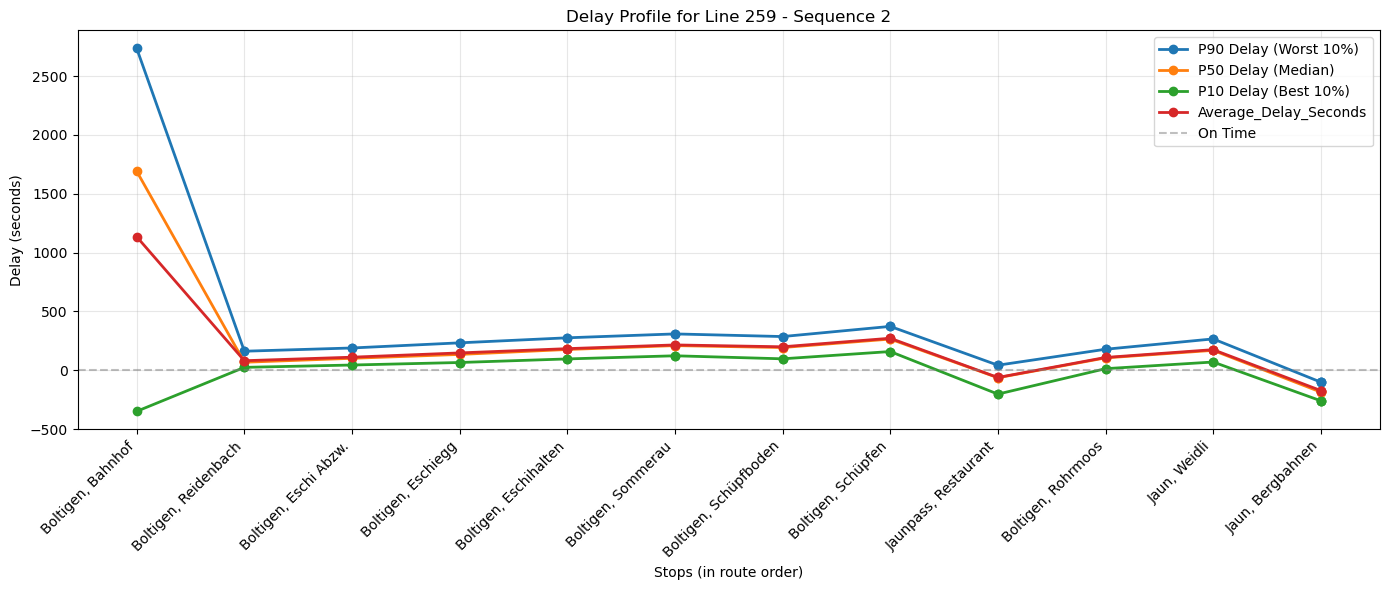

📊 Summary for Line 259 Sequence 2
  - Stops plotted: 24
  - Average P50 delay: 160.5 seconds
  - Worst stop (P90): Boltigen, Bahnhof (2734.5s)


In [80]:
import matplotlib.pyplot as plt

def plot_delay_profile_for_line(df, line_sequences, line, sequence_id=None):
    """
    Plot delay profile (P90, P50, P10) along the stops of a given line sequence.
    
    Parameters:
    df: DataFrame like stop_line_direction_delay_df
    line_sequences: Your line_sequences dictionary from sequence analysis
    line: Line number to visualize
    sequence_id: Optional. If specified, filters on this sequence/direction only
    
    Returns:
    Matplotlib plot showing delay profiles per stop
    """
    df_filtered = df[df['Line'] == line].copy()
    
    if sequence_id is not None:
        df_filtered = df_filtered[df_filtered['Direction'] == sequence_id]
    
    if df_filtered.empty:
        print("❌ No data found for the given line (and sequence if specified).")
        return
    
    # Get the correct order from sequence
    if sequence_id is not None and line in line_sequences and sequence_id in line_sequences[line]:
        # Get the sequence order using Didok IDs
        didok_sequence = line_sequences[line][sequence_id]
        
        # Create a mapping of Didok to position
        didok_to_position = {str(didok): i for i, didok in enumerate(didok_sequence)}
        
        # Add position column and sort by it
        df_filtered['Position'] = df_filtered['Didok'].astype(str).map(didok_to_position)
        df_filtered = df_filtered.dropna(subset=['Position']).sort_values('Position')
    else:
        # If no sequence specified, just sort by Didok (fallback)
        df_filtered = df_filtered.sort_values('Didok')
    
    if df_filtered.empty:
        print("❌ No matching stops found in the sequence data.")
        return
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_filtered['StopName'], df_filtered['P90_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P90 Delay (Worst 10%)')
    plt.plot(df_filtered['StopName'], df_filtered['P50_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P50 Delay (Median)')
    plt.plot(df_filtered['StopName'], df_filtered['P10_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P10 Delay (Best 10%)')
    plt.plot(df_filtered['StopName'], df_filtered['Average_Delay_Seconds'],
             marker='o', linewidth=2, markersize=6, label='Average_Delay_Seconds')
    
    # Add zero line for reference
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='On Time')
    
    plt.title(f"Delay Profile for Line {line}" + 
              (f" - Sequence {sequence_id}" if sequence_id is not None else " (All Sequences)"))
    plt.xlabel("Stops (in route order)")
    plt.ylabel("Delay (seconds)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"📊 Summary for Line {line}" + (f" Sequence {sequence_id}" if sequence_id else ""))
    print(f"  - Stops plotted: {len(df_filtered)}")
    print(f"  - Average P50 delay: {df_filtered['P50_Delay_Seconds'].mean():.1f} seconds")
    print(f"  - Worst stop (P90): {df_filtered.loc[df_filtered['P90_Delay_Seconds'].idxmax(), 'StopName']} ({df_filtered['P90_Delay_Seconds'].max():.1f}s)")

# Usage examples:
# Show all sequences for a line
# plot_delay_profile_for_line(stop_line_direction_delay_df, line_sequences, line=259)

# Show specific sequence
plot_delay_profile_for_line(stop_line_direction_delay_df, line_sequences, line=259, sequence_id=2)
# Ulmiz FR, Abzw. Lurtigen
# Châtel-St-Denis, Les Moilles 492
# Tafers, Oberdorf 123 182 917 181
# Ulmiz FR, Abzw. Lurtigen

## Line pasenger flow

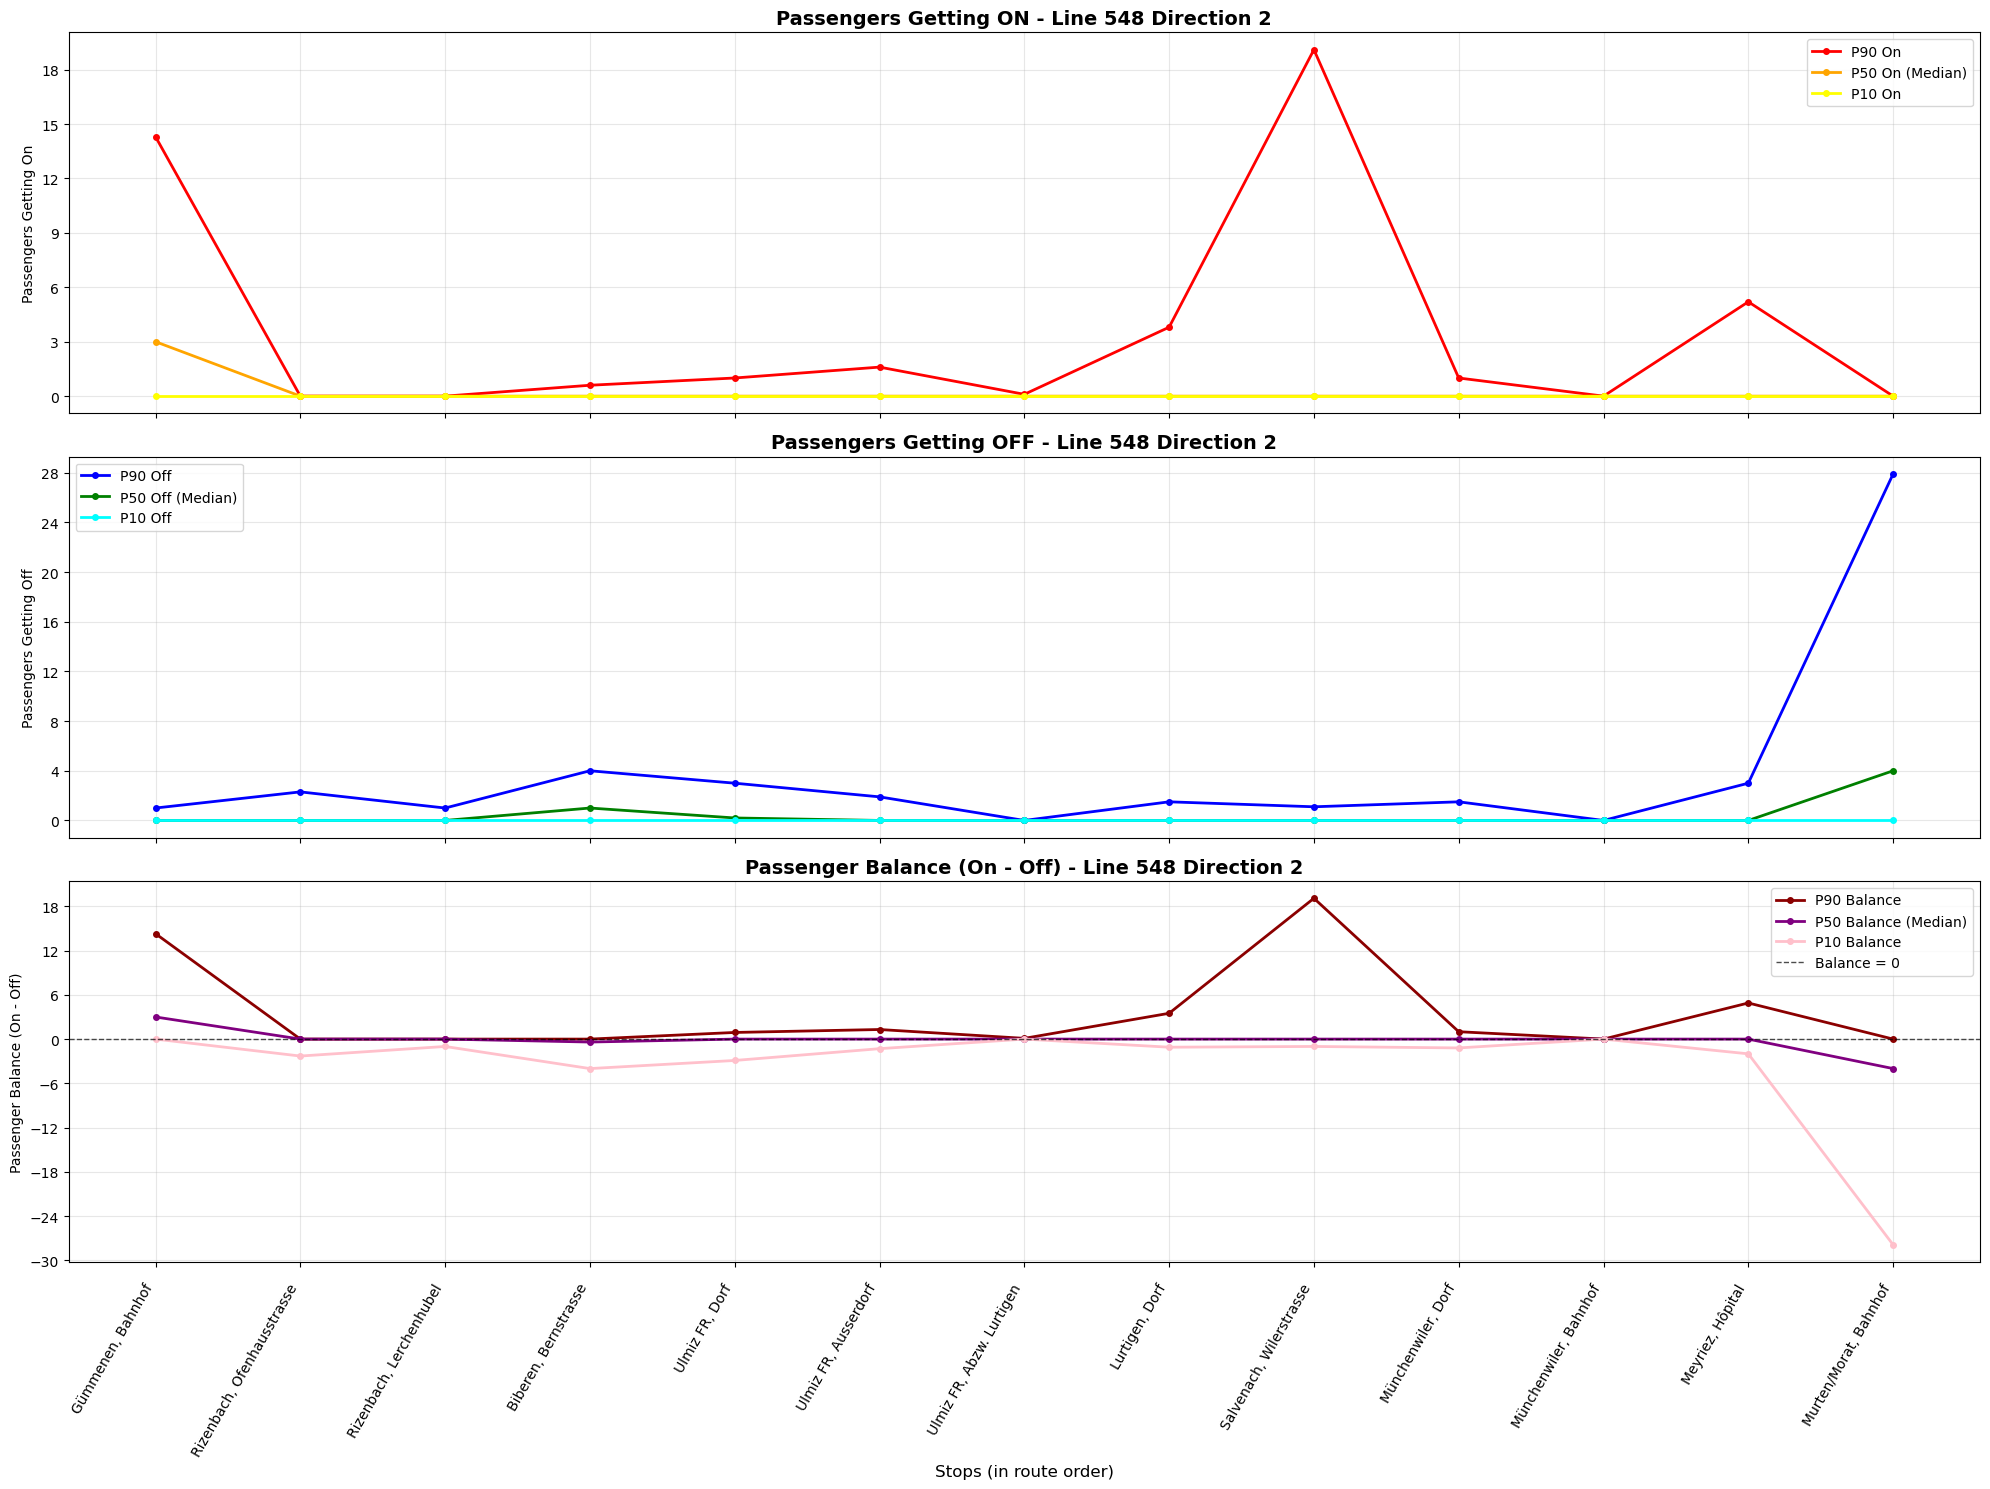

📊 Comprehensive Passenger Analysis for Line 548 Direction 2
  - Stops analyzed: 13
  - Data source: plcs_with_on_off (Second Class only)
  - Boarding-dominant stops (P50 > 0): 1
  - Alighting-dominant stops (P50 < 0): 2
  - Highest net boarding: Gümmenen, Bahnhof (+3.0 median)
  - Highest total boarding: Gümmenen, Bahnhof (3.0 median)
  - Highest net alighting: Murten/Morat, Bahnhof (-4.0 median)
  - Highest total alighting: Murten/Morat, Bahnhof (4.0 median)


In [82]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_passenger_comprehensive_profile_plcs(plcs_df, line_sequences, line, direction=None):
    """
    Plot comprehensive passenger profile using plcs_with_on_off DataFrame.
    
    Parameters:
    plcs_df: DataFrame (plcs_with_on_off data)
    line_sequences: Your line_sequences dictionary
    line: Line number to visualize
    direction: Direction ID (from your sequence analysis)
    """
    
    # Filter by line
    df_filtered = plcs_df[plcs_df['Line'] == line].copy()
    
    if df_filtered.empty:
        print(f"❌ No data found for line {line}.")
        return
    
    # Filter by direction if specified (plcs already has Direction column!)
    if direction is not None:
        df_filtered = df_filtered[df_filtered['Direction'] == direction]
        if df_filtered.empty:
            print(f"❌ No data found for line {line}, direction {direction}.")
            return
    
    # Calculate total passengers and balance
    # Note: plcs_with_on_off only has Second_Class data, assuming First_Class = 0
    df_filtered['On_First_Class'] = 0.0  # Add missing First Class data
    df_filtered['Off_First_Class'] = 0.0  # Add missing First Class data
    
    df_filtered['Total_On'] = df_filtered['On_First_Class'] + df_filtered['On_Second_Class']
    df_filtered['Total_Off'] = df_filtered['Off_First_Class'] + df_filtered['Off_Second_Class']
    df_filtered['Total_Balance'] = df_filtered['Total_On'] - df_filtered['Total_Off']
    
    # plcs_with_on_off already has StopName and Didok columns!
    # No need for mapping like in the original function
    
    # Group by stop and calculate percentiles
    stop_stats = df_filtered.groupby(['Stop', 'StopName', 'Didok']).agg({
        'Total_On': [lambda x: x.quantile(0.1), lambda x: x.quantile(0.5), lambda x: x.quantile(0.9)],
        'Total_Off': [lambda x: x.quantile(0.1), lambda x: x.quantile(0.5), lambda x: x.quantile(0.9)],
        'Total_Balance': [lambda x: x.quantile(0.1), lambda x: x.quantile(0.5), lambda x: x.quantile(0.9)]
    }).round(1)
    
    # Flatten column names
    stop_stats.columns = [
        'On_P10', 'On_P50', 'On_P90', 
        'Off_P10', 'Off_P50', 'Off_P90',
        'Balance_P10', 'Balance_P50', 'Balance_P90'
    ]
    stop_stats = stop_stats.reset_index()
    
    # Handle duplicate StopNames by averaging numeric columns
    numeric_cols = ['On_P10', 'On_P50', 'On_P90', 'Off_P10', 'Off_P50', 'Off_P90', 
                    'Balance_P10', 'Balance_P50', 'Balance_P90']
    other_cols = ['Stop', 'Didok']
    
    agg_dict = {col: 'mean' for col in numeric_cols}
    agg_dict.update({col: 'first' for col in other_cols})
    
    stop_stats = stop_stats.groupby('StopName').agg(agg_dict).reset_index()
    
    # Get sequence order using Didok IDs if direction specified
    if direction is not None and line in line_sequences and direction in line_sequences[line]:
        # Get the sequence order (Didok IDs)
        didok_sequence = line_sequences[line][direction]
        
        # Create a mapping of Didok to position
        didok_to_position = {str(didok): i for i, didok in enumerate(didok_sequence)}
        
        # Add position column and sort by it
        stop_stats['Position'] = stop_stats['Didok'].astype(str).map(didok_to_position)
        stop_stats = stop_stats.dropna(subset=['Position'])
        stop_stats = stop_stats.sort_values('Position')
    else:
        # If no direction specified, sort by Stop (fallback)
        stop_stats = stop_stats.sort_values('Stop')
    
    if stop_stats.empty:
        print("❌ No stops found after filtering and ordering.")
        return
    
    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))
    
    # Plot 1: Passengers getting ON
    ax1.plot(stop_stats['StopName'], stop_stats['On_P90'], marker='o', label='P90 On', color='red', linewidth=2, markersize=4)
    ax1.plot(stop_stats['StopName'], stop_stats['On_P50'], marker='o', label='P50 On (Median)', color='orange', linewidth=2, markersize=4)
    ax1.plot(stop_stats['StopName'], stop_stats['On_P10'], marker='o', label='P10 On', color='yellow', linewidth=2, markersize=4)
    ax1.set_title(f"Passengers Getting ON - Line {line}" + (f" Direction {direction}" if direction else ""), fontsize=14, fontweight='bold')
    ax1.set_ylabel("Passengers Getting On")
    ax1.tick_params(axis='x', rotation=60, which='major', pad=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Plot 2: Passengers getting OFF
    ax2.plot(stop_stats['StopName'], stop_stats['Off_P90'], marker='o', label='P90 Off', color='blue', linewidth=2, markersize=4)
    ax2.plot(stop_stats['StopName'], stop_stats['Off_P50'], marker='o', label='P50 Off (Median)', color='green', linewidth=2, markersize=4)
    ax2.plot(stop_stats['StopName'], stop_stats['Off_P10'], marker='o', label='P10 Off', color='cyan', linewidth=2, markersize=4)
    ax2.set_title(f"Passengers Getting OFF - Line {line}" + (f" Direction {direction}" if direction else ""), fontsize=14, fontweight='bold')
    ax2.set_ylabel("Passengers Getting Off")
    ax2.tick_params(axis='x', rotation=60, which='major', pad=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Plot 3: Passenger Balance (On - Off)
    ax3.plot(stop_stats['StopName'], stop_stats['Balance_P90'], marker='o', label='P90 Balance', color='darkred', linewidth=2, markersize=4)
    ax3.plot(stop_stats['StopName'], stop_stats['Balance_P50'], marker='o', label='P50 Balance (Median)', color='purple', linewidth=2, markersize=4)
    ax3.plot(stop_stats['StopName'], stop_stats['Balance_P10'], marker='o', label='P10 Balance', color='pink', linewidth=2, markersize=4)
    
    # Zero line for balance reference
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1, label='Balance = 0')
    
    ax3.set_title(f"Passenger Balance (On - Off) - Line {line}" + (f" Direction {direction}" if direction else ""), fontsize=14, fontweight='bold')
    ax3.set_xlabel("Stops (in route order)", fontsize=12)
    ax3.set_ylabel("Passenger Balance (On - Off)")
    ax3.tick_params(axis='x', rotation=60, which='major', pad=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Align x-tick labels for all subplots
    for ax in [ax1, ax2, ax3]:
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')
    
    # Only show x-labels on the bottom plot
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print(f"📊 Comprehensive Passenger Analysis for Line {line}" + (f" Direction {direction}" if direction else ""))
    print(f"  - Stops analyzed: {len(stop_stats)}")
    print(f"  - Data source: plcs_with_on_off (Second Class only)")
    
    # Analyze boarding vs alighting patterns
    boarding_stops = stop_stats[stop_stats['Balance_P50'] > 0]
    alighting_stops = stop_stats[stop_stats['Balance_P50'] < 0]
    
    print(f"  - Boarding-dominant stops (P50 > 0): {len(boarding_stops)}")
    print(f"  - Alighting-dominant stops (P50 < 0): {len(alighting_stops)}")
    
    if len(boarding_stops) > 0:
        max_boarding = boarding_stops.loc[boarding_stops['Balance_P50'].idxmax()]
        print(f"  - Highest net boarding: {max_boarding['StopName']} (+{max_boarding['Balance_P50']:.1f} median)")
        
        max_on = stop_stats.loc[stop_stats['On_P50'].idxmax()]
        print(f"  - Highest total boarding: {max_on['StopName']} ({max_on['On_P50']:.1f} median)")
    
    if len(alighting_stops) > 0:
        max_alighting = alighting_stops.loc[alighting_stops['Balance_P50'].idxmin()]
        print(f"  - Highest net alighting: {max_alighting['StopName']} ({max_alighting['Balance_P50']:.1f} median)")
        
        max_off = stop_stats.loc[stop_stats['Off_P50'].idxmax()]
        print(f"  - Highest total alighting: {max_off['StopName']} ({max_off['Off_P50']:.1f} median)")

# Usage:
plot_passenger_comprehensive_profile_plcs(plcs_with_on_off, line_sequences, line=548, direction=2)